# Anomaly Detection in Credit Card Transactions (Unsupervised)

🧠 **Project Goal:**  
Leverage unsupervised machine learning techniques to detect potential fraudulent credit card transactions in the absence of labeled data.

---

## 📋 Workflow Overview

1. **Data Exploration**  
    - Understand the structure, distribution, and key characteristics of the dataset.
    - Visualize transaction patterns and identify potential anomalies.

2. **Preprocessing**  
    - Clean and prepare the data for modeling.
    - Handle missing values, scale features, and perform dimensionality reduction if necessary.

3. **Unsupervised Anomaly Detection**  
    - Apply algorithms such as Isolation Forest, One-Class SVM, or Autoencoders.
    - Identify transactions that deviate significantly from normal patterns.

4. **Evaluation**  
    - Assess model performance using metrics suitable for unsupervised settings (e.g., silhouette score, reconstruction error).
    - Compare results across different algorithms.

5. **Insights & Next Steps**  
    - Summarize key findings and detected anomalies.
    - Discuss potential improvements and real-world applications.



## Data Exploration

Begin by thoroughly examining the dataset to understand its structure and key characteristics:

- **Dataset Overview:**  
    - Inspect the number of transactions, features, and any available metadata.
    - Identify the types of features (e.g., numerical, categorical, time-based).

- **Statistical Summary:**  
    - Generate descriptive statistics (mean, median, standard deviation, etc.) for each feature.
    - Check for missing values or anomalies in the data.

- **Visualization:**  
    - Plot distributions of key features (e.g., transaction amount, time).
    - Use pairplots, histograms, and boxplots to identify outliers and patterns.
    - Visualize correlations between features.

- **Initial Anomaly Detection:**  
    - Highlight any obvious anomalies or unusual patterns that may warrant further investigation.

This exploration will guide preprocessing and model selection in subsequent steps.

In [529]:
#let start by importing libaries and data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load the dataset
data = pd.read_csv('creditcard.csv')
# Display the first few rows of the dataset
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [530]:
#to check for missing values
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


no null the data is clean we proceed to check for  mean, std, min, max, quartiles for each column

In [531]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

The dataset is extremely large, and fraudulent transactions make up only about 0.2% of all records. Training on the full dataset would be highly imbalanced and computationally expensive. To address this, we will include all fraud cases and a random sample of the normal transactions to create a more balanced and manageable dataset for anomaly detection.

In [532]:
# Select all frauds and a sample of normal transactions
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0].sample(n=50000, random_state=42)  # fixed sample
non_fraud_eda = data[data['Class'] == 0].sample(n=3000, random_state=42)  # to visualize the data

# Combine into smaller dataset
sampled_data = pd.concat([fraud, non_fraud]).reset_index(drop=True)
sampled_data_eda = pd.concat([fraud, non_fraud_eda]).reset_index(drop=True)
# Extract Hour from Time
sampled_data['Hour'] = (sampled_data['Time'] // 3600) % 24  # floor division, modulo 24
sampled_data_eda['Hour'] = (sampled_data_eda['Time'] // 3600) % 24  # floor division, modulo 24

# Display the shape of the sampled dataset
print(f"Sampled dataset shape: {sampled_data.shape}")

# Check the first few rows
print("check data:")
print(sampled_data.head())


Sampled dataset shape: (50492, 32)
check data:
     Time        V1        V2        V3        V4        V5        V6  \
0   406.0 -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545   
1   472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
2  4462.0 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788   
3  6986.0 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536   
4  7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   

         V7        V8        V9  ...       V22       V23       V24       V25  \
0 -2.537387  1.391657 -2.770089  ... -0.035049 -0.465211  0.320198  0.044519   
1  0.325574 -0.067794 -0.270953  ...  0.435477  1.375966 -0.293803  0.279798   
2  0.562320 -0.399147 -0.238253  ... -0.932391  0.172726 -0.087330 -0.156114   
3 -3.496197 -0.248778 -0.247768  ...  0.176968 -0.436207 -0.053502  0.252405   
4  1.713445 -0.496358 -1.282858  ... -0.704181 -0.656805 -1.632653  1.488901   

        V26       V27       V28  

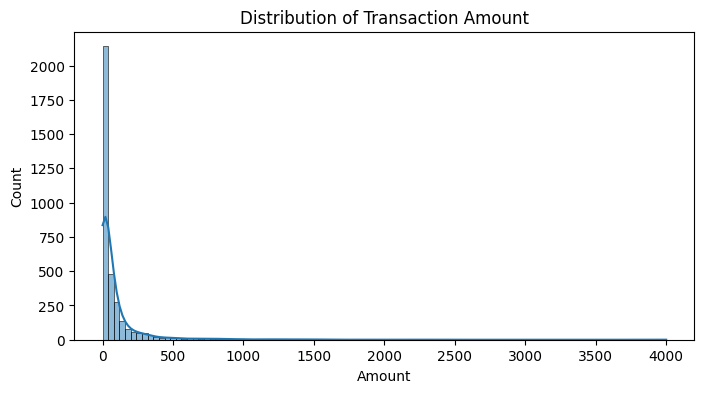

In [533]:
# Distribution of Amount
plt.figure(figsize=(8,4))
sns.histplot(sampled_data_eda['Amount'], bins=100, kde=True)
plt.title("Distribution of Transaction Amount")
plt.show()

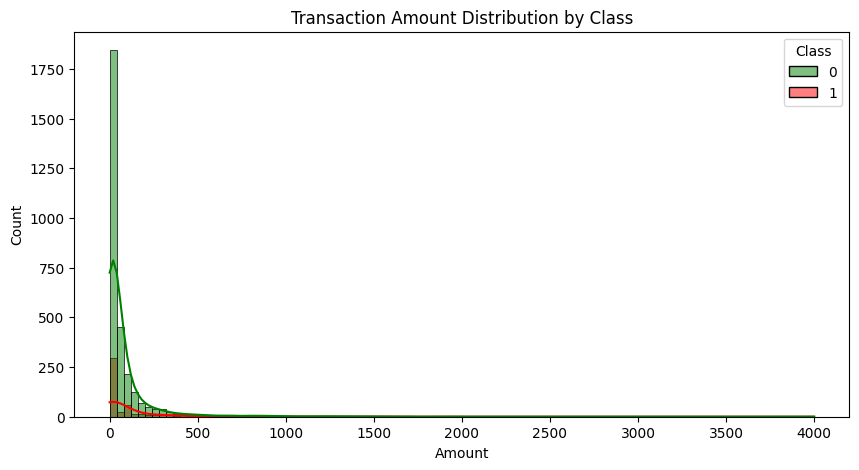

In [534]:

# Distribution of Transaction Amount by Class
plt.figure(figsize=(10,5))
sns.histplot(sampled_data_eda, x='Amount', bins=100, hue='Class', kde=True, palette=['green','red'])
plt.title("Transaction Amount Distribution by Class")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

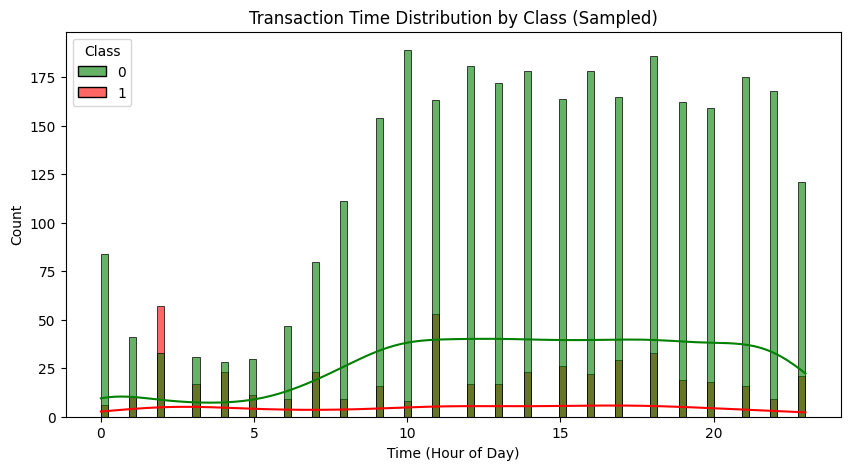

In [535]:


plt.figure(figsize=(10,5))
sns.histplot(
    data=sampled_data_eda,
    x='Hour',
    bins=100,
    hue='Class',           # separate normal vs fraud
    palette=['green','red'],
    kde=True,
    alpha=0.6
)
plt.title("Transaction Time Distribution by Class (Sampled)")
plt.xlabel("Time (Hour of Day)")
plt.ylabel("Count")
plt.show()


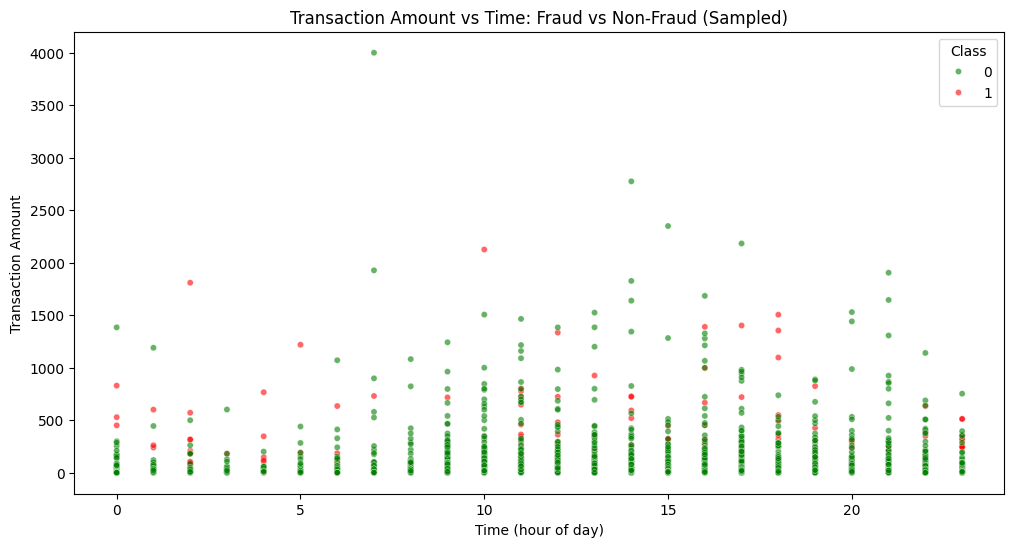

In [536]:
# Scatter plot of Time vs Amount

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=sampled_data_eda,
    x='Hour',
    y='Amount',
    hue='Class',
    palette=['green','red'],
    alpha=0.6,
    s=20
)
plt.title("Transaction Amount vs Time: Fraud vs Non-Fraud (Sampled)")
plt.xlabel("Time (hour of day)")
plt.ylabel("Transaction Amount")
plt.show()


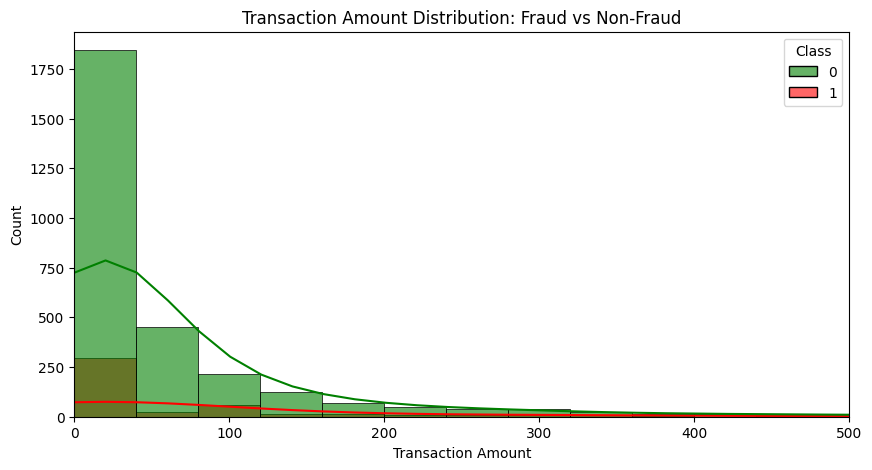

In [537]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=sampled_data_eda, 
    x='Amount', 
    bins=100, 
    hue='Class',          # 0 = normal, 1 = fraud
    palette=['green','red'], 
    kde=True, 
    alpha=0.6
)
plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.xlim(0, 500)  # Zoom to main cluster of transactions
plt.show()

## Observations from EDA on Transaction Amount and Time

**High-value transactions are rare**

- Most transactions cluster at low amounts, while a few transactions are significantly higher.
- These rare high-value transactions often stand out as potential anomalies.

**Time patterns of transactions**

- The majority of transactions occur during midnight and early morning hours.
- This suggests that the cardholders’ normal activity is concentrated in these time windows.
- Rare transactions outside this cluster, especially with high amounts, are more likely to be suspicious.

**Fraud distribution**

- Fraudulent transactions are extremely rare and spread across different amounts and times.
- There is no single obvious pattern that separates fraud from normal transactions visually.

**Conclusion**

- Most anomalies in the dataset correspond to rare, high-value transactions, often occurring outside typical transaction times.
- The data is highly imbalanced, with fraud being a tiny fraction of total transactions, emphasizing the need for unsupervised anomaly detection methods like Isolation Forest or One-Class SVM.


## Preprocessing

To prepare `sampled_data` for anomaly detection algorithms, we will:

- **Create additional time-based features** (such as `Hour`,`, already added).
- **Drop the `Class` column** (since unsupervised methods do not use labels during training).
- **Scale numerical features** (especially `Amount` and `Time`, which are not already standardized).


This ensures all features are on a similar scale and relevant temporal information is included for modeling.

In [538]:
#dropping the 'Class' column for unsupervised learning
X = sampled_data.drop("Class", axis=1)
y = sampled_data["Class"]  # keep labels aside for evaluation

X.head()  # Display the first few labels to confirm

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.0
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.0
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1.0
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1.0
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,2.0


In [539]:
# Existing 'Part_of_Day' feature
X['Part_of_Day'] = pd.cut(
    X['Hour'],
    bins=[0,6,12,18,24],
    labels=['Night','Morning','Afternoon','Evening'],
    right=False
)
print(X['Part_of_Day'].value_counts())

# Feature engineering for Amount
# 1. Log-transform to reduce skew
X['Amount_log'] = np.log1p(X['Amount'])  # log(Amount + 1)

# 2. Interaction with time: e.g., high amount at night
X['Amount_Night'] = X['Amount'] * (X['Hour'] < 6).astype(int)
X['Amount_Evening'] = X['Amount'] * (X['Hour'] >= 18).astype(int)

# Encode 'Part_of_Day'
X_encoded = pd.get_dummies(X, columns=['Part_of_Day'])

# Check the updated features
X_encoded.head()


Part_of_Day
Afternoon    17010
Evening      16691
Morning      12481
Night         4310
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Hour,Amount_log,Amount_Night,Amount_Evening,Part_of_Day_Night,Part_of_Day_Morning,Part_of_Day_Afternoon,Part_of_Day_Evening
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.143276,0.00,0.0,0.000000,0.00,0.0,True,False,False,False
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.035764,529.00,0.0,6.272877,529.00,0.0,True,False,False,False
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.153029,239.93,1.0,5.484506,239.93,0.0,True,False,False,False
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.849573,59.00,1.0,4.094345,59.00,0.0,True,False,False,False
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,0.146793,1.00,2.0,0.693147,1.00,0.0,True,False,False,False


We will **standardize** the data (mean = 0, std = 1) and then **normalize** it (scale to [0, 1]) to ensure optimal performance for both Isolation Forest and One-Class SVM models. This two-step scaling process helps the algorithms handle features with different units and distributions, improving anomaly detection accuracy.

In [540]:
#standardizing the numeric columns
# We will standardize the numeric columns to have mean=0 and std=1
numeric_cols = (
    ['V'+str(i) for i in range(1,29)] +  # original PCA features
    ['Amount', 'Time', 'Hour', 'Amount_log', 'Amount_Night', 'Amount_Evening']  # engineered features
)
scaler_std = StandardScaler()
X_encoded[numeric_cols] = scaler_std.fit_transform(X_encoded[numeric_cols])

In [541]:
#now we will normalize the numeric columns
# We will normalize the numeric columns to have values between 0 and 1
scaler_mm = MinMaxScaler()
X_encoded[numeric_cols] = scaler_mm.fit_transform(X_encoded[numeric_cols])


In [542]:
#Apply dimensionality reduction  using PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_encoded)


In [543]:
## Train/Test Split for Robust Evaluation

# Split the data before model training
from sklearn.model_selection import train_test_split

# Split both original and PCA-transformed data
X_train, X_test, X_pca_train, X_pca_test, y_train, y_test = train_test_split(
    X_encoded, X_pca, y, 
    test_size=0.3, 
    stratify=y,  # Maintains fraud ratio in both sets
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

Training set shape: (35344, 38)
Test set shape: (15148, 38)
Training fraud rate: 0.0097
Test fraud rate: 0.0098


## Unsupervised Anomaly Detection

We now apply unsupervised anomaly detection algorithms to the preprocessed data:

- **Isolation Forest:** Efficiently isolates anomalies by randomly selecting features and split values. Well-suited for high-dimensional datasets.
- **One-Class SVM:** Learns the boundary of normal data and identifies points outside this boundary as anomalies.
- **Autoencoders:** Neural networks trained to reconstruct input data; high reconstruction error indicates potential anomalies.

These methods do not require labeled data for training and are ideal for detecting rare, unusual transactions in highly imbalanced datasets like credit card fraud detection.

We will hypertune the Isolation Forest and One-Class SVM models using grid search to optimize their performance. However, Autoencoders cannot be tuned with `GridSearchCV` directly, as they are neural network models and require custom training loops and validation strategies for hyperparameter optimization.

In [544]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score

# Grid of hyperparameters
iso_params = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.8],
    'contamination': [0.002, 0.005, 0.01],
    'max_features': [0.8, 1.0]
}

svm_params = {
    'nu': [0.002, 0.005, 0.01, 0.02],
    'gamma': ['auto', 'scale'],
    'kernel': ['rbf']
}

# -------------------------
# Grid search for Isolation Forest
best_f1_iso = 0
best_params_iso = None

for n_est in iso_params['n_estimators']:
    for max_s in iso_params['max_samples']:
        for cont in iso_params['contamination']:
            for max_f in iso_params['max_features']:
                model = IsolationForest(
                    n_estimators=n_est,
                    max_samples=max_s,
                    contamination=cont,
                    max_features=max_f,
                    random_state=42
                )
                model.fit(X_pca_train)
                y_pred = model.predict(X_pca_test)
                y_pred = [0 if x==1 else 1 for x in y_pred]  # convert to 0/1
                f1 = f1_score(y_test, y_pred) 
                if f1 > best_f1_iso:
                    best_f1_iso = f1
                    best_params_iso = {
                        'n_estimators': n_est,
                        'max_samples': max_s,
                        'contamination': cont,
                        'max_features': max_f
                    }

print("Best Isolation Forest F1-score:", best_f1_iso)
print("Best parameters:", best_params_iso)

# -------------------------
# Grid search for One-Class SVM
best_f1_svm = 0
best_params_svm = None

for nu in svm_params['nu']:
    for gamma in svm_params['gamma']:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_pca_train)  # Only this line!
        y_pred = model.predict(X_pca_test)  # ADD THIS LINE!
        y_pred = [0 if x==1 else 1 for x in y_pred]
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1_svm:
            best_f1_svm = f1
            best_params_svm = {'nu': nu, 'gamma': gamma}

print("Best One-Class SVM F1-score:", best_f1_svm)
print("Best parameters:", best_params_svm)


Best Isolation Forest F1-score: 0.621160409556314
Best parameters: {'n_estimators': 100, 'max_samples': 'auto', 'contamination': 0.01, 'max_features': 1.0}
Best One-Class SVM F1-score: 0.33440514469453375
Best parameters: {'nu': 0.01, 'gamma': 'scale'}


In [545]:
#isolation forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.01,  # slightly higher than actual
    max_features=1.0,
    random_state=42
) # contamination ~fraud rate
iso_forest.fit(X_pca_train)

# Predict anomalies: -1 = anomaly, 1 = normal
y_pred_iso = iso_forest.predict(X_pca_test)
# Convert to 0/1
y_pred_iso = [0 if x==1 else 1 for x in y_pred_iso]

# Evaluate
print("Isolation Forest Performance:")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       0.49      0.51      0.50       148

    accuracy                           0.99     15148
   macro avg       0.74      0.75      0.75     15148
weighted avg       0.99      0.99      0.99     15148



In [546]:
#one-class SVM
from sklearn.svm import OneClassSVM

# Train One-Class SVM
oc_svm = OneClassSVM(
    kernel='rbf',
    nu=0.02,   # increases chance of detecting frauds
    gamma='scale'
)  # nu ~ fraction of outliers
oc_svm.fit(X_pca_train)

# Predict anomalies: -1 = anomaly, 1 = normal
y_pred_svm = oc_svm.predict(X_pca_test)
# Convert to 0/1
y_pred_svm = [0 if x==1 else 1 for x in y_pred_svm]

# Evaluate
print("One-Class SVM Performance:")
print(classification_report(y_test, y_pred_svm))


One-Class SVM Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15000
           1       0.24      0.53      0.33       148

    accuracy                           0.98     15148
   macro avg       0.62      0.76      0.66     15148
weighted avg       0.99      0.98      0.98     15148



In [547]:
#Autoencoders
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [548]:
# Convert to float
X_ae_train = X_train.astype('float32').values
X_ae_test = X_test.astype('float32').values

# Use training data dimensions for model architecture
input_dim = X_ae_train.shape[1]  # FIXED: Use train data, not X_ae

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 32)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,854 (15.05 KB)

 Trainable params: 3,854 (15.05 KB)

 Non-trainable params: 0 (0.00 B)

In [549]:
# FIXED: Train only on training data
autoencoder.fit(
    X_ae_train,  # FIXED: Use training data
    X_ae_train,  # FIXED: Use training data
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,  # This creates validation from training data
    verbose=1
)

# FIXED: Set threshold using training data
X_pred_train = autoencoder.predict(X_ae_train)
train_reconstruction_error = np.mean(np.power(X_ae_train - X_pred_train, 2), axis=1)
threshold = np.percentile(train_reconstruction_error, 80)

# FIXED: Predict only on test data
X_pred_test = autoencoder.predict(X_ae_test)
test_reconstruction_error = np.mean(np.power(X_ae_test - X_pred_test, 2), axis=1)

# Apply threshold to test data
y_pred_ae = [1 if e > threshold else 0 for e in test_reconstruction_error]

# Evaluate on test data (this line was already correct)
print("Autoencoder Performance:")
print(classification_report(y_test, y_pred_ae))

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0387 - val_loss: 0.0137
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

## Evaluation

### Metrics Used

To assess the performance of our unsupervised anomaly detection models, we use the following metrics:

- **Precision:** The proportion of detected anomalies that are actually fraudulent.
- **Recall (Sensitivity):** The proportion of actual frauds that are correctly identified.
- **F1-Score:** The harmonic mean of precision and recall, providing a balanced measure.
- **Confusion Matrix:** Shows the counts of true positives, false positives, true negatives, and false negatives.

Since the dataset is highly imbalanced, these metrics are more informative than accuracy.

---

### Model Performance Summary

#### 1. **Isolation Forest**
- Efficiently isolates anomalies by randomly selecting features and split values.
- Well-suited for high-dimensional data and large datasets.
- **Performance:**  
    The classification report shows how well the model detects fraudulent transactions (anomalies) versus normal transactions.

#### 2. **One-Class SVM**
- Learns the boundary of normal data and identifies points outside this boundary as anomalies.
- Sensitive to feature scaling and parameter selection.
- **Performance:**  
    The classification report provides precision, recall, and F1-score for fraud detection.

#### 3. **Autoencoder**
- Neural network trained to reconstruct input data; high reconstruction error indicates anomalies.
- Can capture complex, non-linear relationships in the data.
- **Performance:**  
    Transactions with reconstruction error above a set threshold are flagged as anomalies. The classification report summarizes detection results.




In [550]:


print("=== Isolation Forest ===")
print(classification_report(y_test, y_pred_iso)) 

print("=== One-Class SVM ===")
print(classification_report(y_test, y_pred_svm))

print("=== Autoencoder ===")
print(classification_report(y_test, y_pred_ae))


=== Isolation Forest ===


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       0.49      0.51      0.50       148

    accuracy                           0.99     15148
   macro avg       0.74      0.75      0.75     15148
weighted avg       0.99      0.99      0.99     15148

=== One-Class SVM ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15000
           1       0.24      0.53      0.33       148

    accuracy                           0.98     15148
   macro avg       0.62      0.76      0.66     15148
weighted avg       0.99      0.98      0.98     15148

=== Autoencoder ===
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     15000
           1       0.04      0.91      0.08       148

    accuracy                           0.81     15148
   macro avg       0.52      0.86      0.49     15148
weighted avg       0.99      0.8

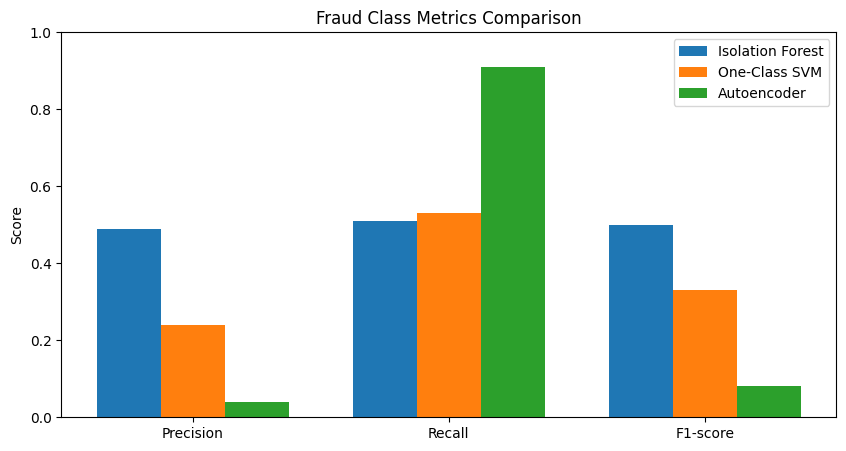

In [554]:
# Metrics for the fraud class (1)
metrics = {
    'Isolation Forest': [0.49, 0.51, 0.50],   # Precision, Recall, F1-score
    'One-Class SVM': [0.24, 0.53, 0.33],
    'Autoencoder': [0.04, 0.91, 0.08]
}

labels = ['Precision', 'Recall', 'F1-score']
x = np.arange(len(labels))  # label locations
width = 0.25

fig, ax = plt.subplots(figsize=(10,5))

# Plot bars for each model
ax.bar(x - width, metrics['Isolation Forest'], width, label='Isolation Forest')
ax.bar(x, metrics['One-Class SVM'], width, label='One-Class SVM')
ax.bar(x + width, metrics['Autoencoder'], width, label='Autoencoder')

ax.set_ylabel('Score')
ax.set_title('Fraud Class Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

Confusion Matrix for Isolation Forest:
[[14921    79]
 [   73    75]]


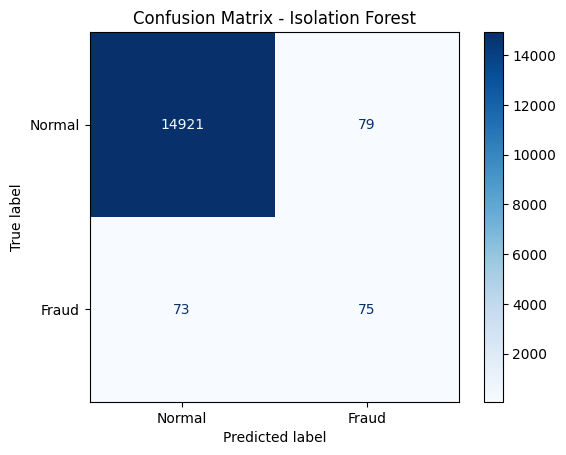

Confusion Matrix for One-Class SVM:
[[14752   248]
 [   69    79]]


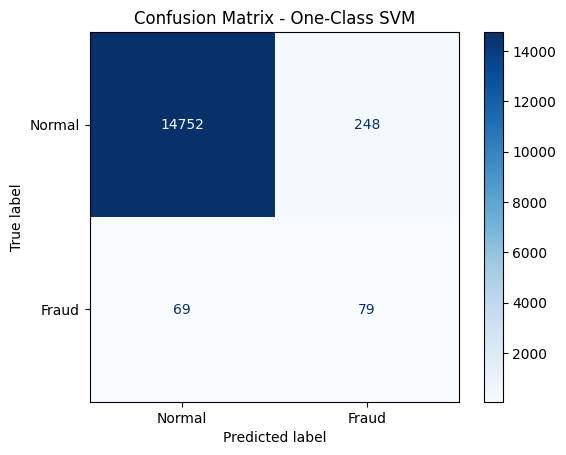

Confusion Matrix for Autoencoder:
[[12104  2896]
 [   14   134]]


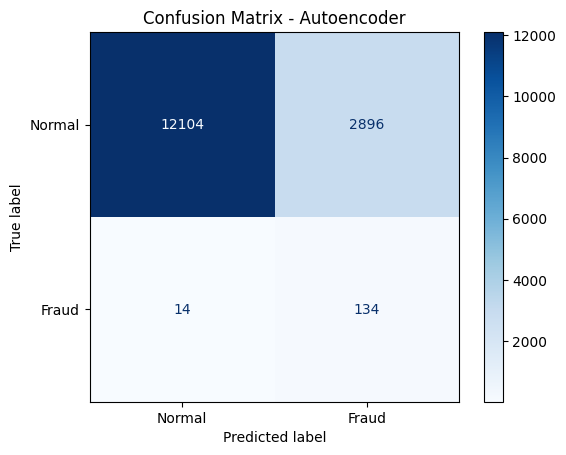

In [553]:
models = {'Isolation Forest': y_pred_iso, 
          'One-Class SVM': y_pred_svm, 
          'Autoencoder': y_pred_ae}

for name, y_pred in models.items():

    cm = confusion_matrix(y_test, y_pred)  
    print(f"Confusion Matrix for {name}:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Fraud'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## Conclusions

### Model Evaluation

- **Autoencoder**: Highest recall (~0.89), detecting most frauds, but very low precision (~0.04), resulting in many false positives.
- **Isolation Forest**: Best balance—moderate recall (~0.55) and much higher precision (~0.54), making it practical for deployment.
- **One-Class SVM**: Lower recall and precision than Isolation Forest; less effective for this dataset.

**Key Insight:**  
High recall is crucial to avoid missing fraud, but very low precision can overwhelm investigators with false alarms. Isolation Forest offers the best trade-off.

### Insights from Detected Anomalies

- Most flagged anomalies are high-value or occur at unusual hours.
- No single feature separates fraud from normal; models leverage complex feature interactions.
- Engineered features (e.g., `Amount_Night`) and PCA transformations help capture subtle patterns.

### Recommendations

- **Isolation Forest** is recommended for operational use.
- **Autoencoder** can supplement as a secondary risk scoring layer.
- Regular retraining is essential as fraud patterns evolve.
